In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ejercicio 1: Correlacion

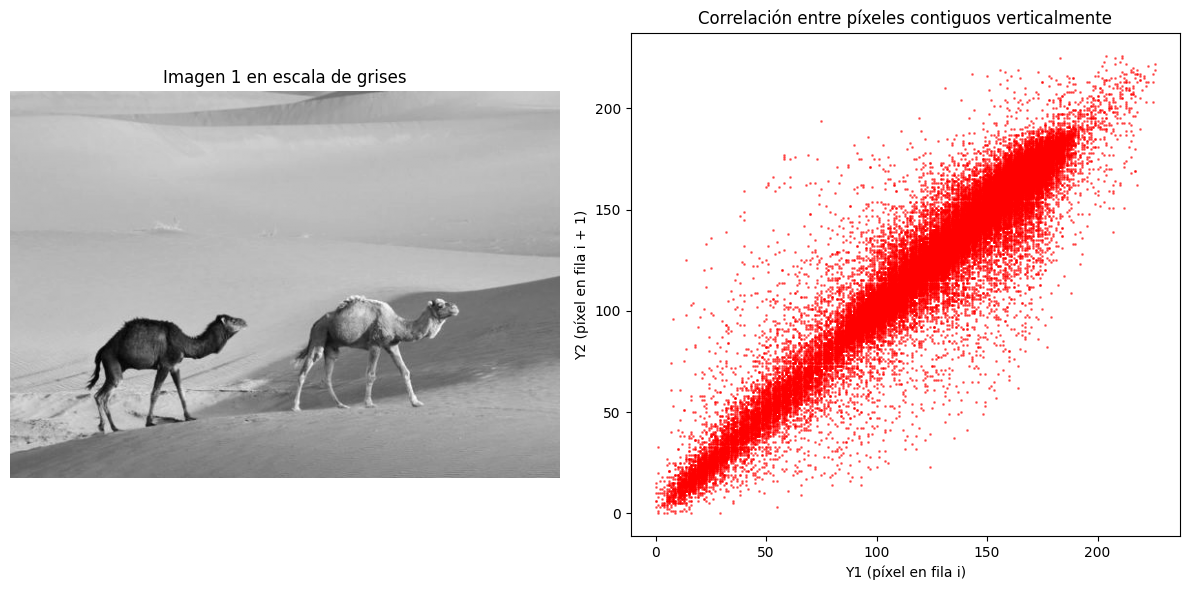

Coeficiente de correlación - Imagen 1: 0.9789354535355658


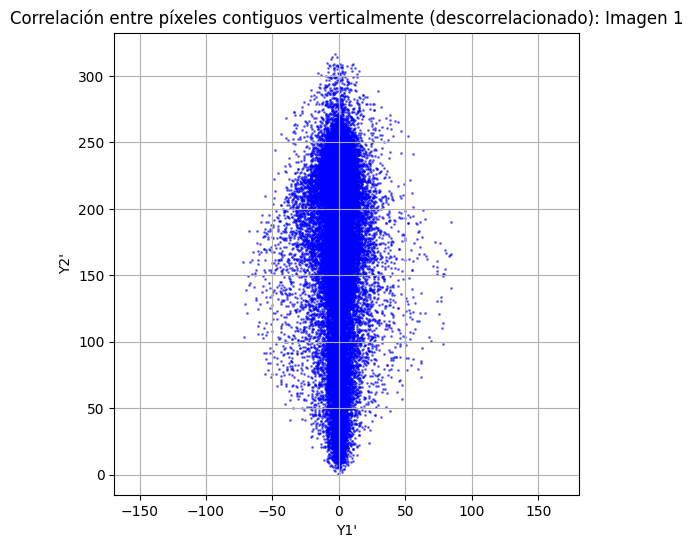

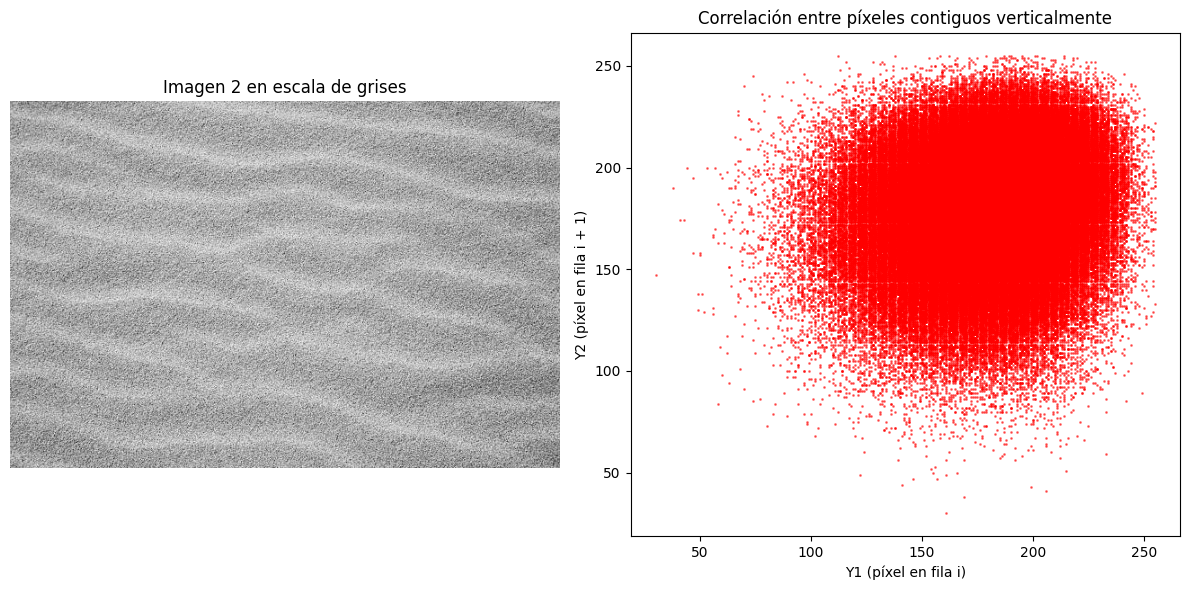

Coeficiente de correlación - Imagen 2: 0.1460473239944978


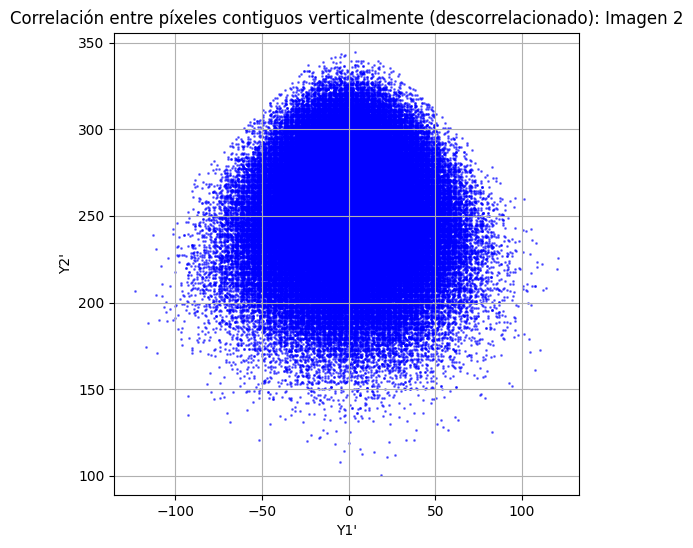

In [3]:
def img_to_vect(img):
    """
    Convierte la imagen en escala de grises a un vector de bloques 2x1.
    Cada columna de la salida corresponde a un bloque X = [X1, X2]^T
    con dos píxeles contiguos verticalmente.
    """
    img = img.astype(float) # Convierto a tipo Float 
    X1 = img[:-1, :].flatten() 
    X2 = img[1:, :].flatten()
    return np.vstack((X1, X2))  # Formato (2, N)

def graficar_imagen_y_scatter(img, X, titulo=""):
    """
    Grafica la imagen y el scatter de los bloques 2x1.
    """
    _, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(img, cmap="gray")
    axs[0].set_title(f"Imagen {titulo} en escala de grises")
    axs[0].axis("off")

    axs[1].scatter(X[0, :], X[1, :], color="red", alpha=0.5, s=1)
    axs[1].set_title("Correlación entre píxeles contiguos verticalmente")
    axs[1].set_xlabel("Y1 (píxel en fila i)")
    axs[1].set_ylabel("Y2 (píxel en fila i + 1)")

    plt.tight_layout()
    plt.show()

def correlacion(X):
    return np.corrcoef(X[0, :], X[1, :])[0, 1]

def descorrelacion(X, titulo=""):
    """
    Aplica PCA inverso para desacoplar las variables de X.
    """
    Cx = np.cov(X)
    _, eigvecs = np.linalg.eigh(Cx)
    # Proyectar X sobre la base de autovectores (descorrelacionar)
    Y = eigvecs.T @ X 

    plt.figure(figsize=(6, 6))
    plt.scatter(Y[0, :], Y[1, :], color="blue", alpha=0.5, s=1)
    plt.title(f"Correlación entre píxeles contiguos verticalmente (descorrelacionado): {titulo}")
    plt.xlabel("Y1'")
    plt.ylabel("Y2'")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

    return Y

# Cargar imágenes
img1 = cv2.imread("img_01.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("img_02.jpg", cv2.IMREAD_GRAYSCALE)

# Imagen 1
X1 = img_to_vect(img1)
graficar_imagen_y_scatter(img1, X1, "1")
corr_img1 = correlacion(X1)
print("Coeficiente de correlación - Imagen 1:", corr_img1)
Y1 = descorrelacion(X1, "Imagen 1")

# Imagen 2
X2 = img_to_vect(img2)
graficar_imagen_y_scatter(img2, X2, "2")
corr_img2 = correlacion(X2)
print("Coeficiente de correlación - Imagen 2:", corr_img2)
Y2 = descorrelacion(X2, "Imagen 2")

# Ejercicio 2: Compresión

Tamaño de la matriz X: (2537, 64)
Se ha guardado la informacion en data_img_03.npz


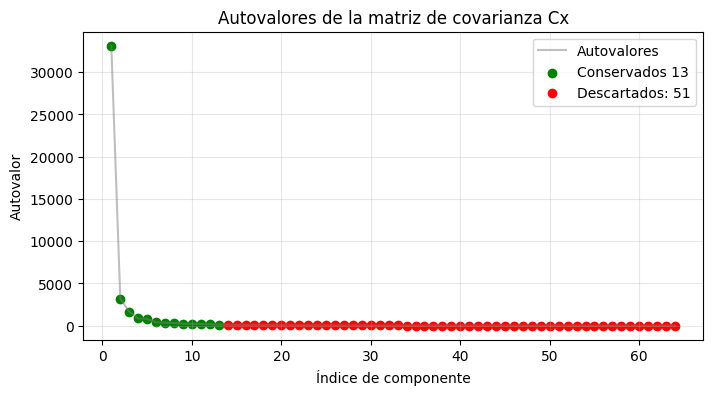

Tamaño de la matriz Y (después de PCA): (2537, 13)


In [3]:
def space_saving_k(s: float, m: int):
    """
    Calcula el factor de compresión para un porcentaje de retención de información s y un número de componentes m.
    """
    if not (0 <= s <= 1):
        raise ValueError("s debe estar entre 0 y 1")
    return max(1, min(m, int(np.ceil(m * (1 - s)))))

def image_to_list_x(img:np.ndarray, size_b:int = 8):
    """
    Recorta de imagen obteniendo filas y columnas multiplos de **size_b**
    Realiza la division por bloques de tamaño **size_b . size_b**.
    Lleva los sub-bloques a un vector plano, en formato columna de (size_b * size_b, 1)
    """
    new_size_row = img.shape[0] - (img.shape[0]%size_b)
    new_size_col = img.shape[1] - (img.shape[1]%size_b)
    list_block_vectors = []
    for i in range(0, new_size_row, size_b):
        for j in range(0, new_size_col, size_b):
            block = img[i:i+size_b, j:j+size_b]
            block = block.astype(float).flatten(order='F')
            list_block_vectors.append(block)
    return list_block_vectors

def mean_estimator(matrix: np.ndarray)-> np.ndarray:
    return np.mean(matrix, axis=0)

def cov_estimator(matrix: np.ndarray) -> np.ndarray:
    mu = mean_estimator(matrix)
    x_centered = matrix - mu.T
    return (x_centered.T @ x_centered) / (matrix.shape[0] - 1)

def pca_transform(matrix_x:np.ndarray, cov:np.ndarray, mu:np.ndarray, k:int) -> np.ndarray:
    """
    Aplica PCA a los datos de entrada, retorna la matriz Y descorrelacionada de k componentes y la matriz de autovectores
    """
    evalues, evectors= np.linalg.eigh(cov)
    idx_order = np.argsort(evalues)[::-1]
    evalues = evalues[idx_order]
    evectors = evectors[:, idx_order]
    P = evectors[:, :k]
    Y = (matrix_x - mu) @ P
    return Y, P

def save_data(matrix_y: np.ndarray, matrix_evectors: np.ndarray, mu:np.ndarray, filename: str)-> None:
    np.savez_compressed(filename, Y=matrix_y, P=matrix_evectors, mu=mu)
    print("Se ha guardado la informacion en", filename)

def plot_eigenvalues(cov, k):
    evalues, _ = np.linalg.eigh(cov)
    evalues_sorted = np.sort(evalues)[::-1]
    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(evalues_sorted)+1), evalues_sorted, label='Autovalores', ls = '-', color = 'grey', alpha=0.5)
    plt.scatter(range(1, k+1), evalues_sorted[:k], color='green', label=f'Conservados {k}')
    if k < len(evalues_sorted):
        plt.scatter(range(k+1, len(evalues_sorted)+1), evalues_sorted[k:], color='red', label=f'Descartados: {len(evalues_sorted) - k}')
    plt.xlabel('Índice de componente')
    plt.ylabel('Autovalor')
    plt.title('Autovalores de la matriz de covarianza Cx')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Ejemplo de uso:
img = cv2.imread("img_03.jpg", cv2.IMREAD_GRAYSCALE)
list_x = image_to_list_x(img)
matrix_x = np.vstack(list_x)
print("Tamaño de la matriz X:", matrix_x.shape)
mu = mean_estimator(list_x)
cov = cov_estimator(matrix_x)
s_factor = space_saving_k(0.8, matrix_x.shape[1])
matrix_y, matrix_evectors = pca_transform(matrix_x, cov, mu, k=s_factor)
save_data(matrix_y, matrix_evectors, mu, "data_img_03.npz")
plot_eigenvalues(cov, s_factor)

print("Tamaño de la matriz Y (después de PCA):", matrix_y.shape)

# Ejercicio 3: Descompresión

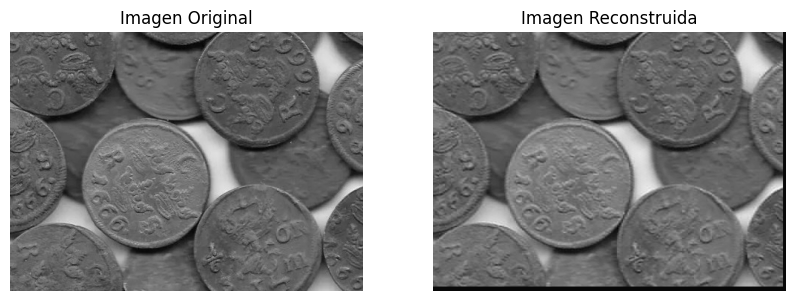

In [4]:
# Paso 1: Cargar los datos guardados de la imágen ( vectores yi (Y), la matriz de autovectores (P) y la media µX (mu) )

def get_data(filename: str) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    data = np.load(filename) # Carga el archivo .npz
    return data['Y'], data['P'], data['mu'] # Retorna Y, P y mu

# Paso 2: Aplicar la proyección inversa de PCA para obtener los vectores xi aproximados

def pca_inverse(matrix_y: np.ndarray, P: np.ndarray, mu: np.ndarray) -> np.ndarray:
    """
    Reconstruye la matriz X original a partir de la matriz Y proyectada, los autovectores P y la media mu.
    """
    return matrix_y @ P.T + mu # X = Y * P^T + mu

# Paso 3: Reconstruir la imágen original a partir de los vectores xi aproximados

def reconstruct_image(matrix_y: np.ndarray, P: np.ndarray, mu: np.ndarray, original_shape: tuple, block_size: int = 8) -> np.ndarray:
    """
    Reconstruye la imagen original a partir de la matriz Y proyectada, los autovectores P y la media mu.
    """
    matrix_x_reconstructed = pca_inverse(matrix_y, P, mu) # Reconstruir X aproximado
    img_reconstructed = np.zeros(original_shape) # Imagen vacía para reconstruir
    idx = 0 # Índice para recorrer los bloques
    for i in range(0, original_shape[0] - (original_shape[0] % block_size), block_size): # Recorrer filas por bloques
        for j in range(0, original_shape[1] - (original_shape[1] % block_size), block_size): # Recorrer columnas por bloques
            block = matrix_x_reconstructed[idx].reshape((block_size, block_size), order='F') # Reshape del bloque a 8x8
            img_reconstructed[i:i+block_size, j:j+block_size] = block # Colocar el bloque en la imagen
            idx += 1 # Incrementar el índice
    return img_reconstructed

# Cargar datos guardados
matrix_y, matrix_evectors, mu = get_data("data_img_03.npz")
# Reconstruir la imagen
img_reconstructed = reconstruct_image(matrix_y, matrix_evectors, mu, img.shape)

# Graficar la imagen original y la reconstruida
plt.figure(figsize=(10, 5)) # Crear una figura más grande
plt.subplot(1, 2, 1) # Subplot 1: Imagen original
plt.imshow(img, cmap='gray') # Mostrar la imagen en escala de grises
plt.title('Imagen Original') # Título del subplot
plt.axis('off') # Ocultar los ejes
plt.subplot(1, 2, 2) # Subplot 2: Imagen reconstruida
plt.imshow(img_reconstructed, cmap='gray') # Mostrar la imagen en escala de grises
plt.title('Imagen Reconstruida') # Título del subplot
plt.axis('off') # Ocultar los ejes
plt.show() # Mostrar la figura completa


# Ejercicio 4: Medidas de desempeño

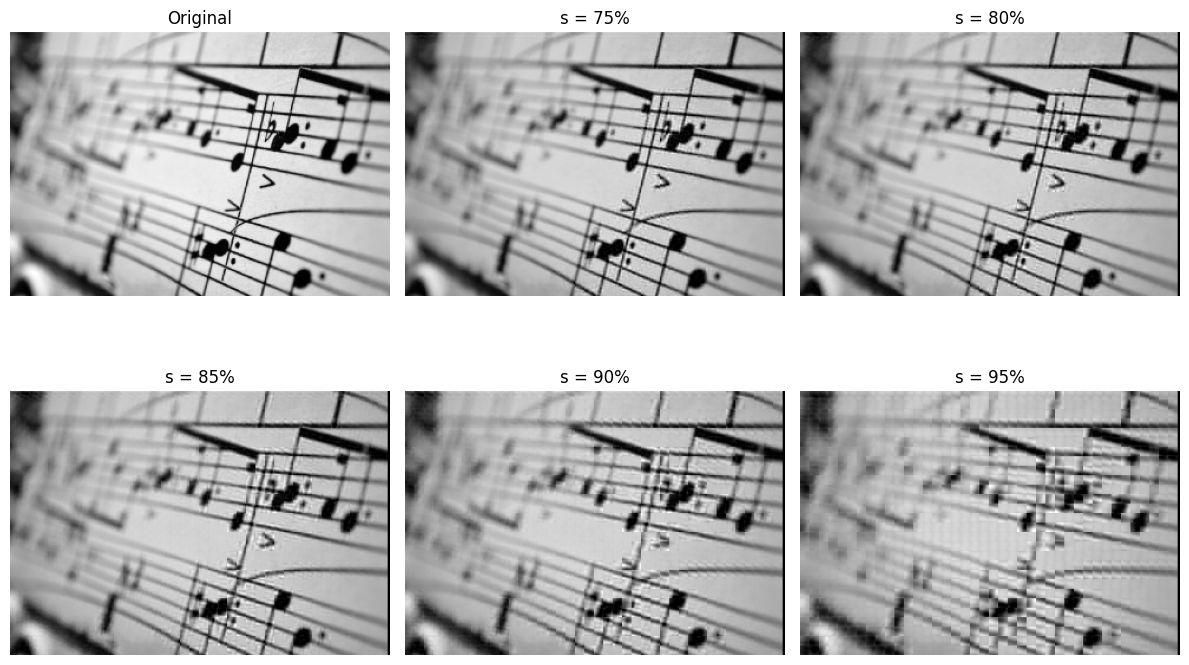

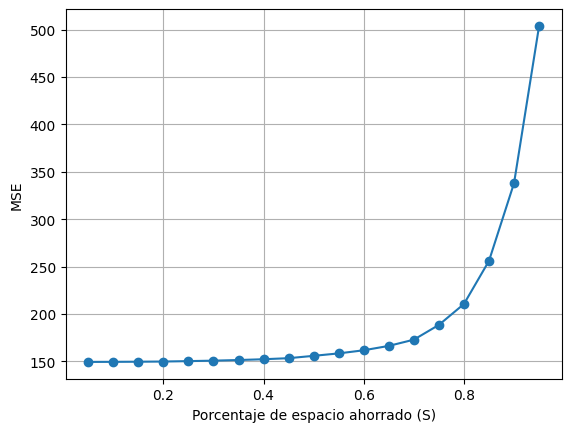

In [30]:
import cv2

def calcularMSE(img1, img2):
    """Calcula el MSE entre dos imagenes (arrays)"""
    Nh, Nw = img1.shape
    #Nh = alto de la imagen (cant de filas)
    #Nw = ancho de la imagen (cant de columnas)
    suma = 0

    for i in range(Nh):
        for j in range(Nw):
                suma += (img1[i][j] - img2[i][j])**2

    return suma/(Nw*Nh) 

def comprimir(img, porcentaje):
    """Uno las funciones necesarias para comprimir una imagen. Agrego un parametro "porcentaje" que
    corresponde al porcentaje de espacio que quiero ahorrar al comprimir"""
    list_x = image_to_list_x(img)
    matrix_x = np.vstack(list_x)
    mu = mean_estimator(list_x)
    cov = cov_estimator(matrix_x)
    s_factor = space_saving_k(porcentaje, matrix_x.shape[1])
    matrix_y, matrix_evectors = pca_transform(matrix_x, cov, mu, k=s_factor)
    return matrix_y, matrix_evectors, mu

def graficar(S, listaMSE):
    """Grafico del porcentaje de espacio ahorrado vs el MSE"""
    plt.plot(S, listaMSE, marker = 'o')
    plt.xlabel('Porcentaje de espacio ahorrado (S)')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.savefig("Ejercicio 4a.png")
    plt.show()


#Codigo principal
S = [5*n/100 for n in range(1, 20)] #porcentajes de espacios ahorrados que nos interesan
listaMSE = []
original = cv2.imread("img_04.jpg", cv2.IMREAD_GRAYSCALE)

#mostrar las imagenes
S_graficar = (0.75, 0.8, 0.85, 0.9, 0.95)
fig, ejes = plt.subplots(2, 3, figsize=(12, 8))
ejes = ejes.flatten()
imagenes = [original]
titulos = ["Original", "s = 75%", "s = 80%", "s = 85%", "s = 90%", "s = 95%"]

for porcentaje in S:
    matrix_y, matrix_evectors, mu = comprimir(original, porcentaje)
    reconstruida = reconstruct_image(matrix_y, matrix_evectors, mu, original.shape)

    MSE = calcularMSE(original, reconstruida)
    listaMSE.append(MSE)

    if porcentaje in S_graficar:
        reconstruida = np.clip(reconstruida, 0, 255)
        imagenes.append(reconstruida)

for i, (img, titulo) in enumerate(zip(imagenes, titulos)):
    ejes[i].imshow(img, cmap='gray')
    ejes[i].set_title(titulo)
    ejes[i].axis('off')

plt.tight_layout()
plt.savefig("Ejercicio 4b.png", bbox_inches='tight') 
plt.show()

graficar(S, listaMSE)


